Importo todas las librerías necesarias para el notebook.

In [37]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import sys, os, warnings, logging
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from IPython.display import clear_output
import random
from sklearn.model_selection import validation_curve
import joblib as jb

Ahora fijo una semilla para que todas las ejecuciones del notebook sean iguales

In [2]:
seed = 2024

# Establecer la semilla para la generación de números aleatorios en Python
random.seed(seed)

# Establecer la semilla para numpy
np.random.seed(seed)


Esta clase permite omitir parte de la salida innecesaria de los modelos, que sobrecargan la salida con información que no nos sirve

# Importo los datos

In [4]:
data = pd.read_csv("Occupancy.csv")
# Elimino el timestamp porque no me interesa usar esta información
data = data.drop(columns=["date"])
data

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.7000,26.2720,585.200000,749.200000,0.004764,1
1,23.7180,26.2900,578.400000,760.400000,0.004773,1
2,23.7300,26.2300,572.666667,769.666667,0.004765,1
3,23.7225,26.1250,493.750000,774.750000,0.004744,1
4,23.7540,26.2000,488.600000,779.000000,0.004767,1
...,...,...,...,...,...,...
20555,20.8150,27.7175,429.750000,1505.250000,0.004213,1
20556,20.8650,27.7450,423.500000,1514.500000,0.004230,1
20557,20.8900,27.7450,423.500000,1521.500000,0.004237,1
20558,20.8900,28.0225,418.750000,1632.000000,0.004279,1


Divido los datos en X e y y los divido en entrenamiento, validación y testeo

In [5]:

# Dividir los datos en características (X) y etiquetas (y)
X = data.drop(columns=["Occupancy"])
y = data["Occupancy"]

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Imprimir las formas de los conjuntos de datos resultantes
print("Forma de X_train:", X_train.shape)
print("Forma de X_val:", X_val.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (12336, 5)
Forma de X_val: (4112, 5)
Forma de X_test: (4112, 5)
Forma de y_train: (12336,)
Forma de y_val: (4112,)
Forma de y_test: (4112,)


# Exploro los datos de entrenamiento

In [6]:
y_train == 0

17053    True
537      True
12767    True
3005     True
6759     True
         ... 
12668    True
15863    True
9929     True
8769     True
10015    True
Name: Occupancy, Length: 12336, dtype: bool

Utilizo matplotlib sobre los datos de entrenamiento para ver la distribución de cada variable para los casos positivos y los negativos.

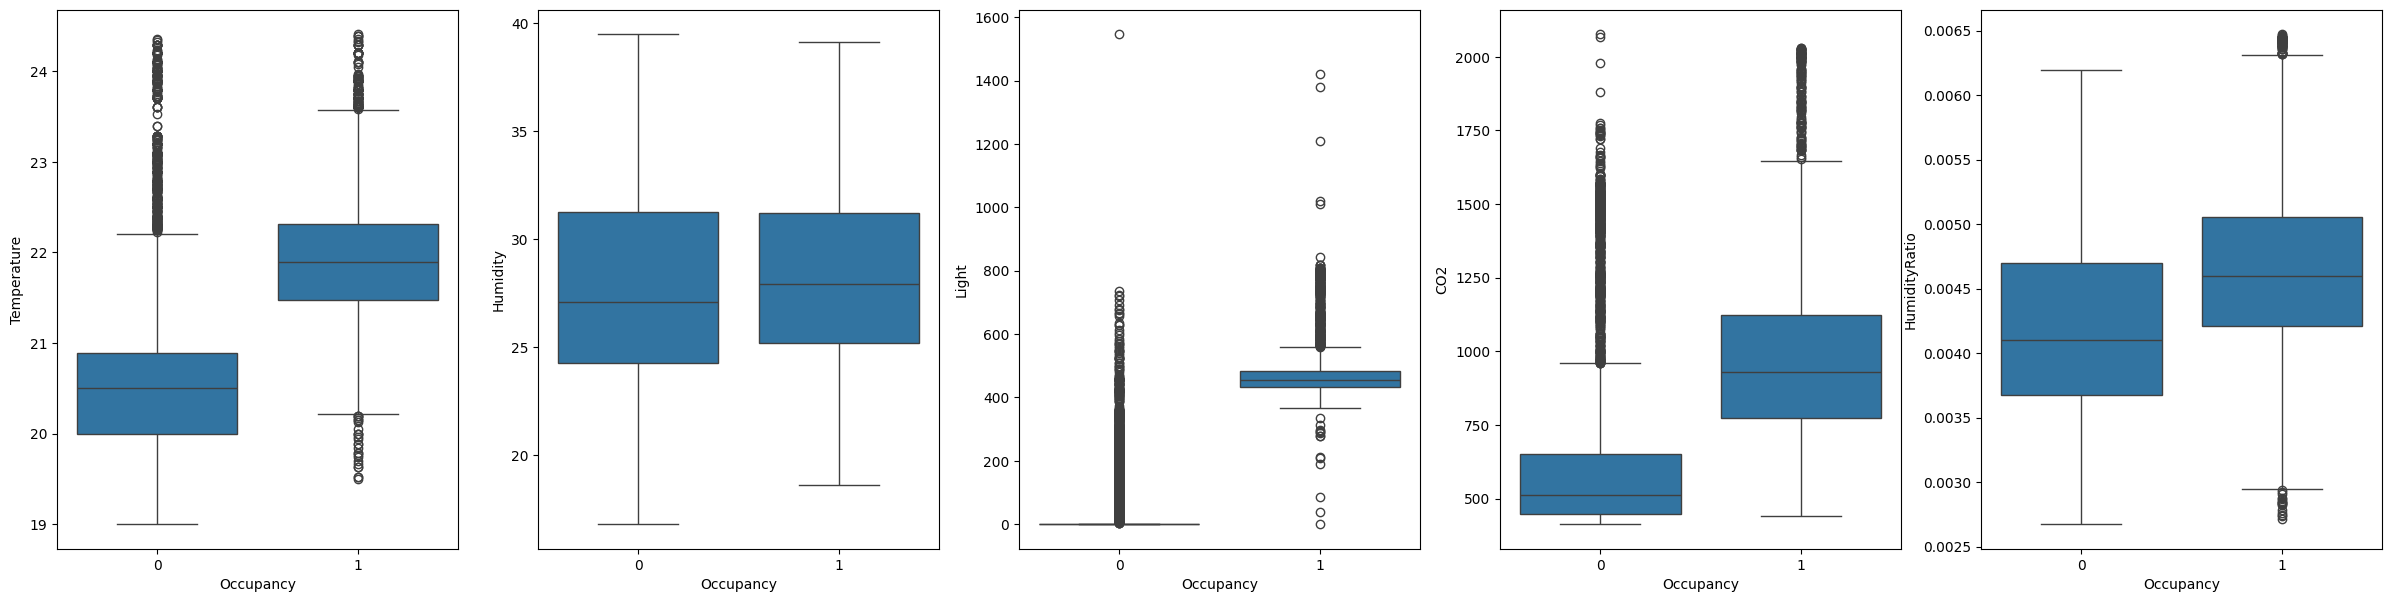

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:


# Create boxplots for each column of X, discriminating by the variable y
fig, axs = plt.subplots(1, 5, figsize=(30, 7))
for (column,ax) in zip(X_train.columns,axs):
    plt.figure()
    sns.boxplot(x=y_train, y=X_train[column], ax=ax)
    # ax.set_xlabel("Occupancy")
    # ax.set_ylabel(column)
clear_output()
plt.show()

De cada variable se observa:
* Temperatura: Parece que está más calido en los momentos en los que hay gente.
* La humedad no muestra grandes diferencias
* La luz tiene distribuciones completamente distintas en ambos casos. Hay mucha más gente en los momentos que hay luz.
* El CO2 también tiene una aparente correlación positiva con la presencia de personas.
* El ratio de humedad tampoco muestra diferencias tna grandes, aunque más notorias que en el nivel absoluto de humedad.

El problema que puede haber es que varios de estos factores en vez de ser consecuencia y algo que permita detectar si hay personas, sean en realidad una causa de que la gente asista o una consecuencia de una causa de que la gente asista, por ejemplo de la hora (hay más calor y luz de día que de noche).

# Plan de Trabajo

El plan de trabajo del presente paper consistirá en 2 etapas:

* **Falla Total de los sensores**
* **Falla Oculta de los sensores**

**Falla Total de los sensores**

En esta primera etapa, se trabaja con unicamente un subconjunto de los sensores habilitados, asumiendo que los demás sensores han fallado completamente y el sístema es conciente de ello y por lo tanto utiliza modelos entrenados especificamente para el conjunto de sensores restantes. Esto tiene similitudes con un ][paper](https://arxiv.org/pdf/2210.02144) ya existente publicado en *IEEE International Conference on Machine Learning and Applications (ICMLA 2022)*, pero en este caso se trabaja con modelos ligeros de tal forma que se pueda tener un modelo acorde a cada subconjunto de sensores, aprovechando que el caso de prueba es particularmente amigable a este enfoque.

**Falla Oculta de los sensores**

En este caso se modelará la falla introduciendo ruido en los sensores, pero sin que el sístema lo detecte, siendo esto algo no contemplado en el trabajo citado. Se busca evaluar la robustez de los modelos originales frente a la introducción de ruido en los datos de validación.

También se evaluará si mejora esta precisión al incorporar **data aumentation**, es decir introducir casos con ruido introducido en los datos de entrenamiento.

**El principal aporte de este trabajo consiste en esa segunda parte.**

**Modelos a comparar**

En las fases anteriores se compararán diversos modelos de aprendizaje automático disponibles en la biblioteca *sklearn*. En principio:
* Regresión Logística
* Random Forest
* SVM (Support Vector Machine)

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC as SupportVectorClassifier


Modelos = [
    (LogisticRegression(random_state=seed), "Regresión Logística"),
    (RandomForestClassifier(random_state=seed), "Random Forest"),
    (SupportVectorClassifier(random_state=seed), "SVM"),
    (GradientBoostingClassifier(random_state=seed), "Gradient Boosting")  
]


# Explicación de los Modelos

# Habilitamos un subconjunto de las variables

La primer prueba comparativa que vamos a hacer consiste en tomar un subconjunto de las variables predictoras y utilizar modelos que solo trabajan con esas variables predictoras.

In [32]:
def Informar(mascara, modelos):
    indices = np.array([(mascara&(2**i)!=0) for i in range(len(X_train.columns))])
    
    X_train_mascara = X_train.iloc[:,indices]
    X_val_mascara = X_val.iloc[:,indices]
    resultados = []
    for (modelo, nombre) in modelos:
        modelo.fit(X_train_mascara, y_train)
        y_pred = modelo.predict(X_val_mascara)
        accuracy = accuracy_score(y_val, y_pred)
        resultados.append(accuracy)

    return (X_train_mascara.columns,list(zip([nombre for (_,nombre) in modelos], resultados)))

Notar que puede tardar varios minutos en ejecutar la siguiente celda, que calcula esta comparación para cada subconjunto

## Generación de Resultados

In [43]:
try:
    rsubconjuntos = jb.load("variables/rsubconjuntos.pkl")
except:
    print("Creando rsubconjuntos")
    rsubconjuntos = []
    for i in tqdm(range(1,2**len(X_train.columns))):
        rsubconjuntos.append(Informar(i, Modelos))
    jb.dump(rsubconjuntos, "variables/rsubconjuntos.pkl")

Creando rsubconjuntos


  0%|          | 0/31 [00:00<?, ?it/s]

In [44]:
rsubconjuntos

[(Index(['Temperature'], dtype='object'),
  [('Regresión Logística', 0.8139591439688716),
   ('Random Forest', 0.8443579766536965),
   ('SVM', 0.8523832684824902),
   ('Gradient Boosting', 0.853112840466926)]),
 (Index(['Humidity'], dtype='object'),
  [('Regresión Logística', 0.7592412451361867),
   ('Random Forest', 0.7903696498054474),
   ('SVM', 0.7592412451361867),
   ('Gradient Boosting', 0.7728599221789884)]),
 (Index(['Temperature', 'Humidity'], dtype='object'),
  [('Regresión Logística', 0.8314688715953308),
   ('Random Forest', 0.935068093385214),
   ('SVM', 0.8686770428015564),
   ('Gradient Boosting', 0.8942120622568094)]),
 (Index(['Light'], dtype='object'),
  [('Regresión Logística', 0.9854085603112841),
   ('Random Forest', 0.9824902723735408),
   ('SVM', 0.9868677042801557),
   ('Gradient Boosting', 0.9861381322957199)]),
 (Index(['Temperature', 'Light'], dtype='object'),
  [('Regresión Logística', 0.9871108949416343),
   ('Random Forest', 0.9878404669260701),
   ('SVM',

## Graficar Resultados

Dada la complejidad de los escenarios y la cantidad de modelos a comparar, es un desafío hacer un gráfico que sintetise bien los resultados. Optaremos por utilizar una métrica que sintetise los resultados obtenidos por los distintos modelos en base a la distribución de la cantidad de sensores fallados:
* $Binomial(p, \lambda)$: La probabilidad de que cada sensor falle es $\lambda$ y hay $p$ sensores. De esta forma, si los sensores activos son $p'$, la probabilidad de esa observación dado $\lambda$ es $ \lambda^{p'} (1-\lambda)^{p-p'}$.
* $Poisson(\lambda)$: La probabilidad de que en un periodo de tiempo (al momento de la medición) se distribuye como una Poisson de parametro $\lambda$.

In [157]:
def Graficar(rsubconjuntos, modelos, distribuciones):
    fig, axs = plt.subplots(len(distribuciones),2, figsize=(15, 7*len(distribuciones)))
    axs = axs.reshape(-1,2)
    for i, distribucion in enumerate(distribuciones):
        axa = axs[i][0]
        axb = axs[i][1]
        
        x = distribucion.get_x()
        ys = []
        max_y = np.zeros(len(x))
        
        for modi in range(len(modelos)):
            y = distribucion.get_y(rsubconjuntos,modi)
            ys.append((modelos[modi][1],y))
            max_y = np.maximum(max_y, y)

        for (nombre, y) in ys:
            axa.plot(x, y, label=nombre)
            axb.plot(x, y/max_y, label=nombre)
        
        axa.set_ylabel("Precisión absoluta", fontsize=16)
        axb.set_ylabel("Precisión relativa al mejor modelo", fontsize=16)
        for j in range(2):
            axs[i][j].set_title(distribucion.get_nombre(), fontsize=22)
            axs[i][j].legend(fontsize=12)
            axs[i][j].set_xlabel(distribucion.get_x_label(), fontsize=16)
            axs[i][j].set_facecolor("whitesmoke")
            axs[i][j].grid(True, which='major', linestyle='-', linewidth=0.8, color='gray')
            axs[i][j].grid(True, which='minor', linestyle='--', linewidth='0.5', color='gray')
            x_minor = (axs[i][j].get_xticks()[1:] + axs[i][j].get_xticks()[:-1])/2
#            axs[i][j].set_xticks(x_minor, minor=True)

            y_minor = (axs[i][j].get_yticks()[1:] + axs[i][j].get_yticks()[:-1])/2
#            axs[i][j].set_yticks(y_minor, minor=True)
            # axs[i][j].set_yticks(list(axs[i][j].get_yticks())+[1])
    return (fig, axs)

In [67]:
class Binomial:
    def __init__(self, n, p0 = 0, p1 = 1, n_points = 1000):
        self.n = n
        self.x = np.linspace(p0,p1,n_points)
    
    def get_x(self):
        return self.x
    
    def get_nombre(self):
        return "Binomial"

    def get_x_label(self):
        return "Probabilidad de fallo en un sensor"

    def get_y(self, rsubconjuntos, i):
        y = []
        tams = np.array([len(r[0]) for r in rsubconjuntos])
        resi = np.array([r[1][i][1] for r in rsubconjuntos])
        for l in self.x:
            y.append(np.sum(resi * (1-l) ** tams * l ** (self.n - tams)))
        return np.array(y)


In [130]:
class Poisson:
    def __init__(self, l0 = 0, l1 = 1, n_points = 1000):
        self.x = np.linspace(l0,l1,n_points)
    
    def get_x(self):
        return self.x
    
    def get_nombre(self):
        return "Poisson"

    def get_x_label(self):
        return "Esperanza de cantidad de fallos en un periodo"

    def get_y(self, rsubconjuntos, i):
        y = []
        tams = np.array([len(rsubconjuntos[-1][0]) - len(r[0]) for r in rsubconjuntos])
        resi = np.array([r[1][i][1] for r in rsubconjuntos])
        for l in self.x:
            pesos = np.exp(-l) * l ** tams / np.array([np.math.factorial(tam) for tam in tams])
            pesos /= np.sum(pesos)
            y.append(np.sum(resi * pesos))
        return np.array(y)


/tmp/ipykernel_13669/2059610848.py:19: RuntimeWarning: invalid value encountered in divide
  axb.plot(x, y/max_y, label=nombre)
/tmp/ipykernel_13669/399781262.py:19: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  pesos = np.exp(-l) * l ** tams / np.array([np.math.factorial(tam) for tam in tams])
/tmp/ipykernel_13669/2485354035.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


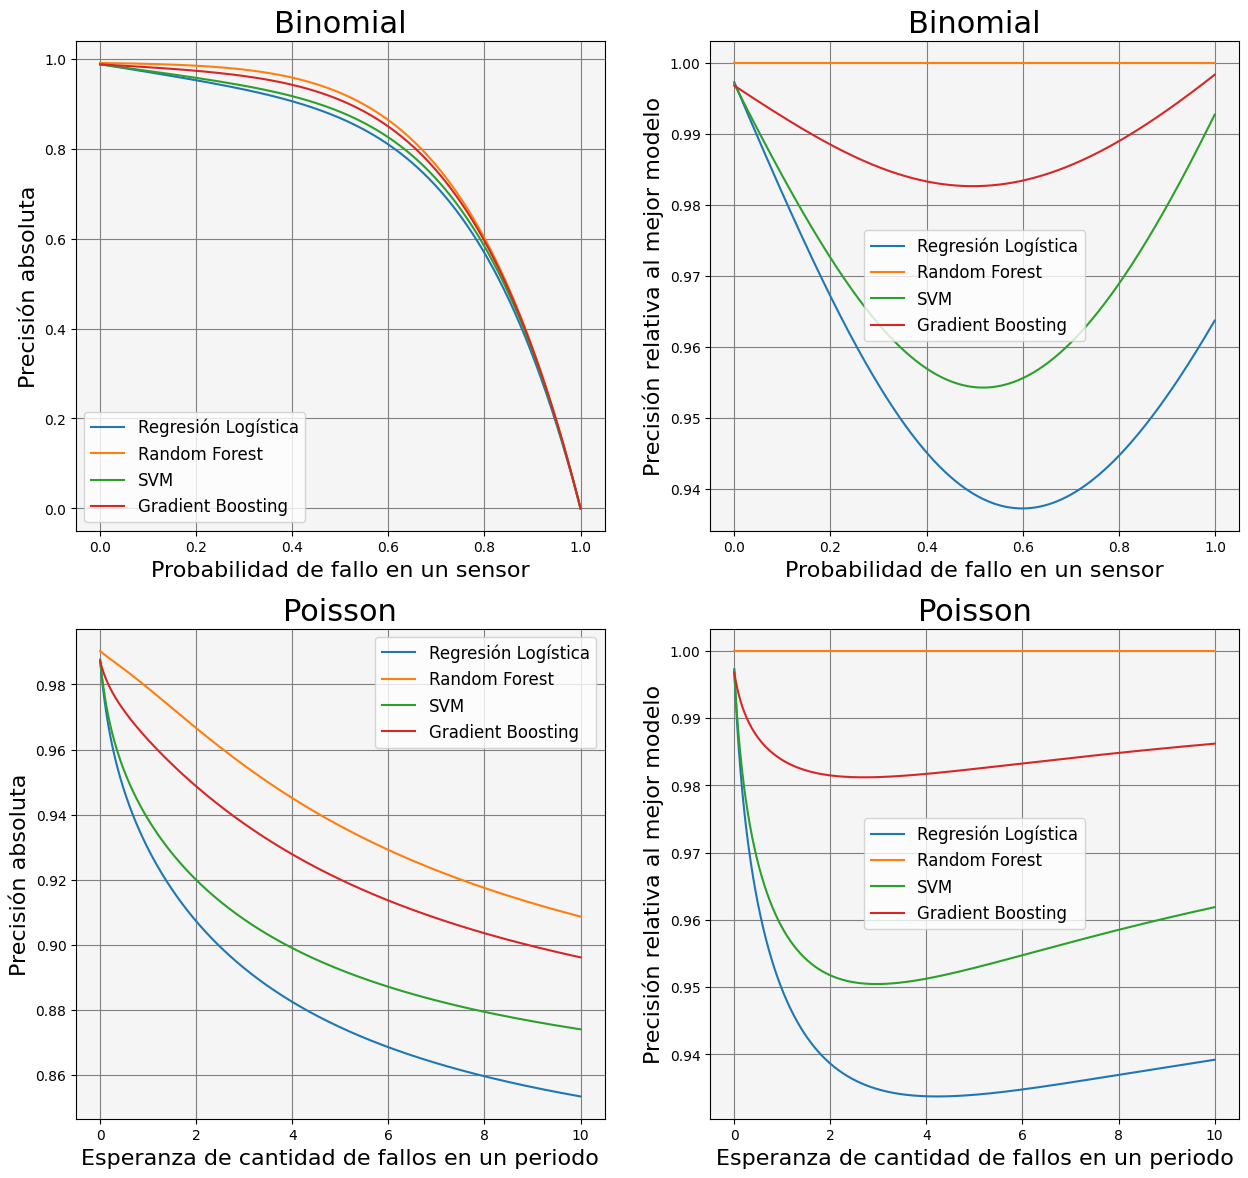

In [158]:
fig,ax = Graficar(rsubconjuntos, Modelos, [Binomial(len(X_train.columns)), 
                                           Poisson(0,2*len(X_train.columns))])
fig.savefig("graficos/precisiones_falla_total.png")
fig.show()

En el siguiente gráfico podemos comparar la performance de ambos modelos

# Incorporar errores

En la siguiente parte compararemos los modelos pero en vez de deshabilitar algunos sensores ( de una forma que es conocida por los modelos), lo que haremos será intrducir errores en un subconjunto de los sensores (sin que los modelos sepan).

Por tanto, entrenaremos los modelos una unica vez y luego solamente los evaluaremos contra datos modificados. Esto hace esta parte notablemente más rápida

In [31]:
with SuppressPrints():
    random_forest = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)
    rf_data = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat([X_train, y_train], axis=1), label="Occupancy")
    random_forest.fit(rf_data)


    logistic = LogisticRegression(len(X_train.columns))
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

    logistic.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    epochs = [10, 10, 200]
    batch_size = [32, 128, len(X_train)]
    learning_rate = [0.1, 0.01, 0.001]

    for (ep, bs) in zip(epochs, batch_size):
        logistic.fit(X_train, y_train, epochs=ep, batch_size=bs)

def Informar_con_error(mascara, alfa = 0):
    global random_forest, logistic, X_val, y_val
    
    indices = np.array([(mascara&(2**i)!=0) for i in range(len(X_train.columns))])
    
    X_val_mascara = X_val.copy()
    
    for i in range(len(X_train.columns)):
        if indices[i]:
            X_val_mascara.iloc[:,i] = X_val_mascara.iloc[:,i]*(1-alfa) + alfa*np.random.normal(
                np.mean(X_val_mascara.iloc[:,i]),
                np.std(X_val_mascara.iloc[:,i]), 
                len(X_val_mascara))
    
    y_pred_val = random_forest.predict(tfdf.keras.pd_dataframe_to_tf_dataset(X_val_mascara))
    
    rf_accuracy = accuracy_score(y_val, y_pred_val>0.5)        
    y_pred_val = logistic.predict(X_val_mascara)
    logistic_accuracy = accuracy_score(y_val, y_pred_val>0.5)

    return (X_train.columns, rf_accuracy, logistic_accuracy) 

clear_output()

Al agregar el error,  $X_i$ pasa a ser  $(1-\alpha) * X_i + \alpha * N(promedio(X),desvio\_standar(X))$

In [32]:
alfas = [0.25, 0.5, 0.75, 1]
with SuppressPrints():
    results_error = [[Informar_con_error(i, alfa) for i in range(1, 2**len(X_train.columns))] for alfa in alfas]
clear_output()

Ahora para cada uno de los niveles de error (0.25 a 1) comparamos la performance de ambos modelos. Tenemos graficos adicionales para hacer zoom en la parte donde están todos los puntos y ver el detalle.

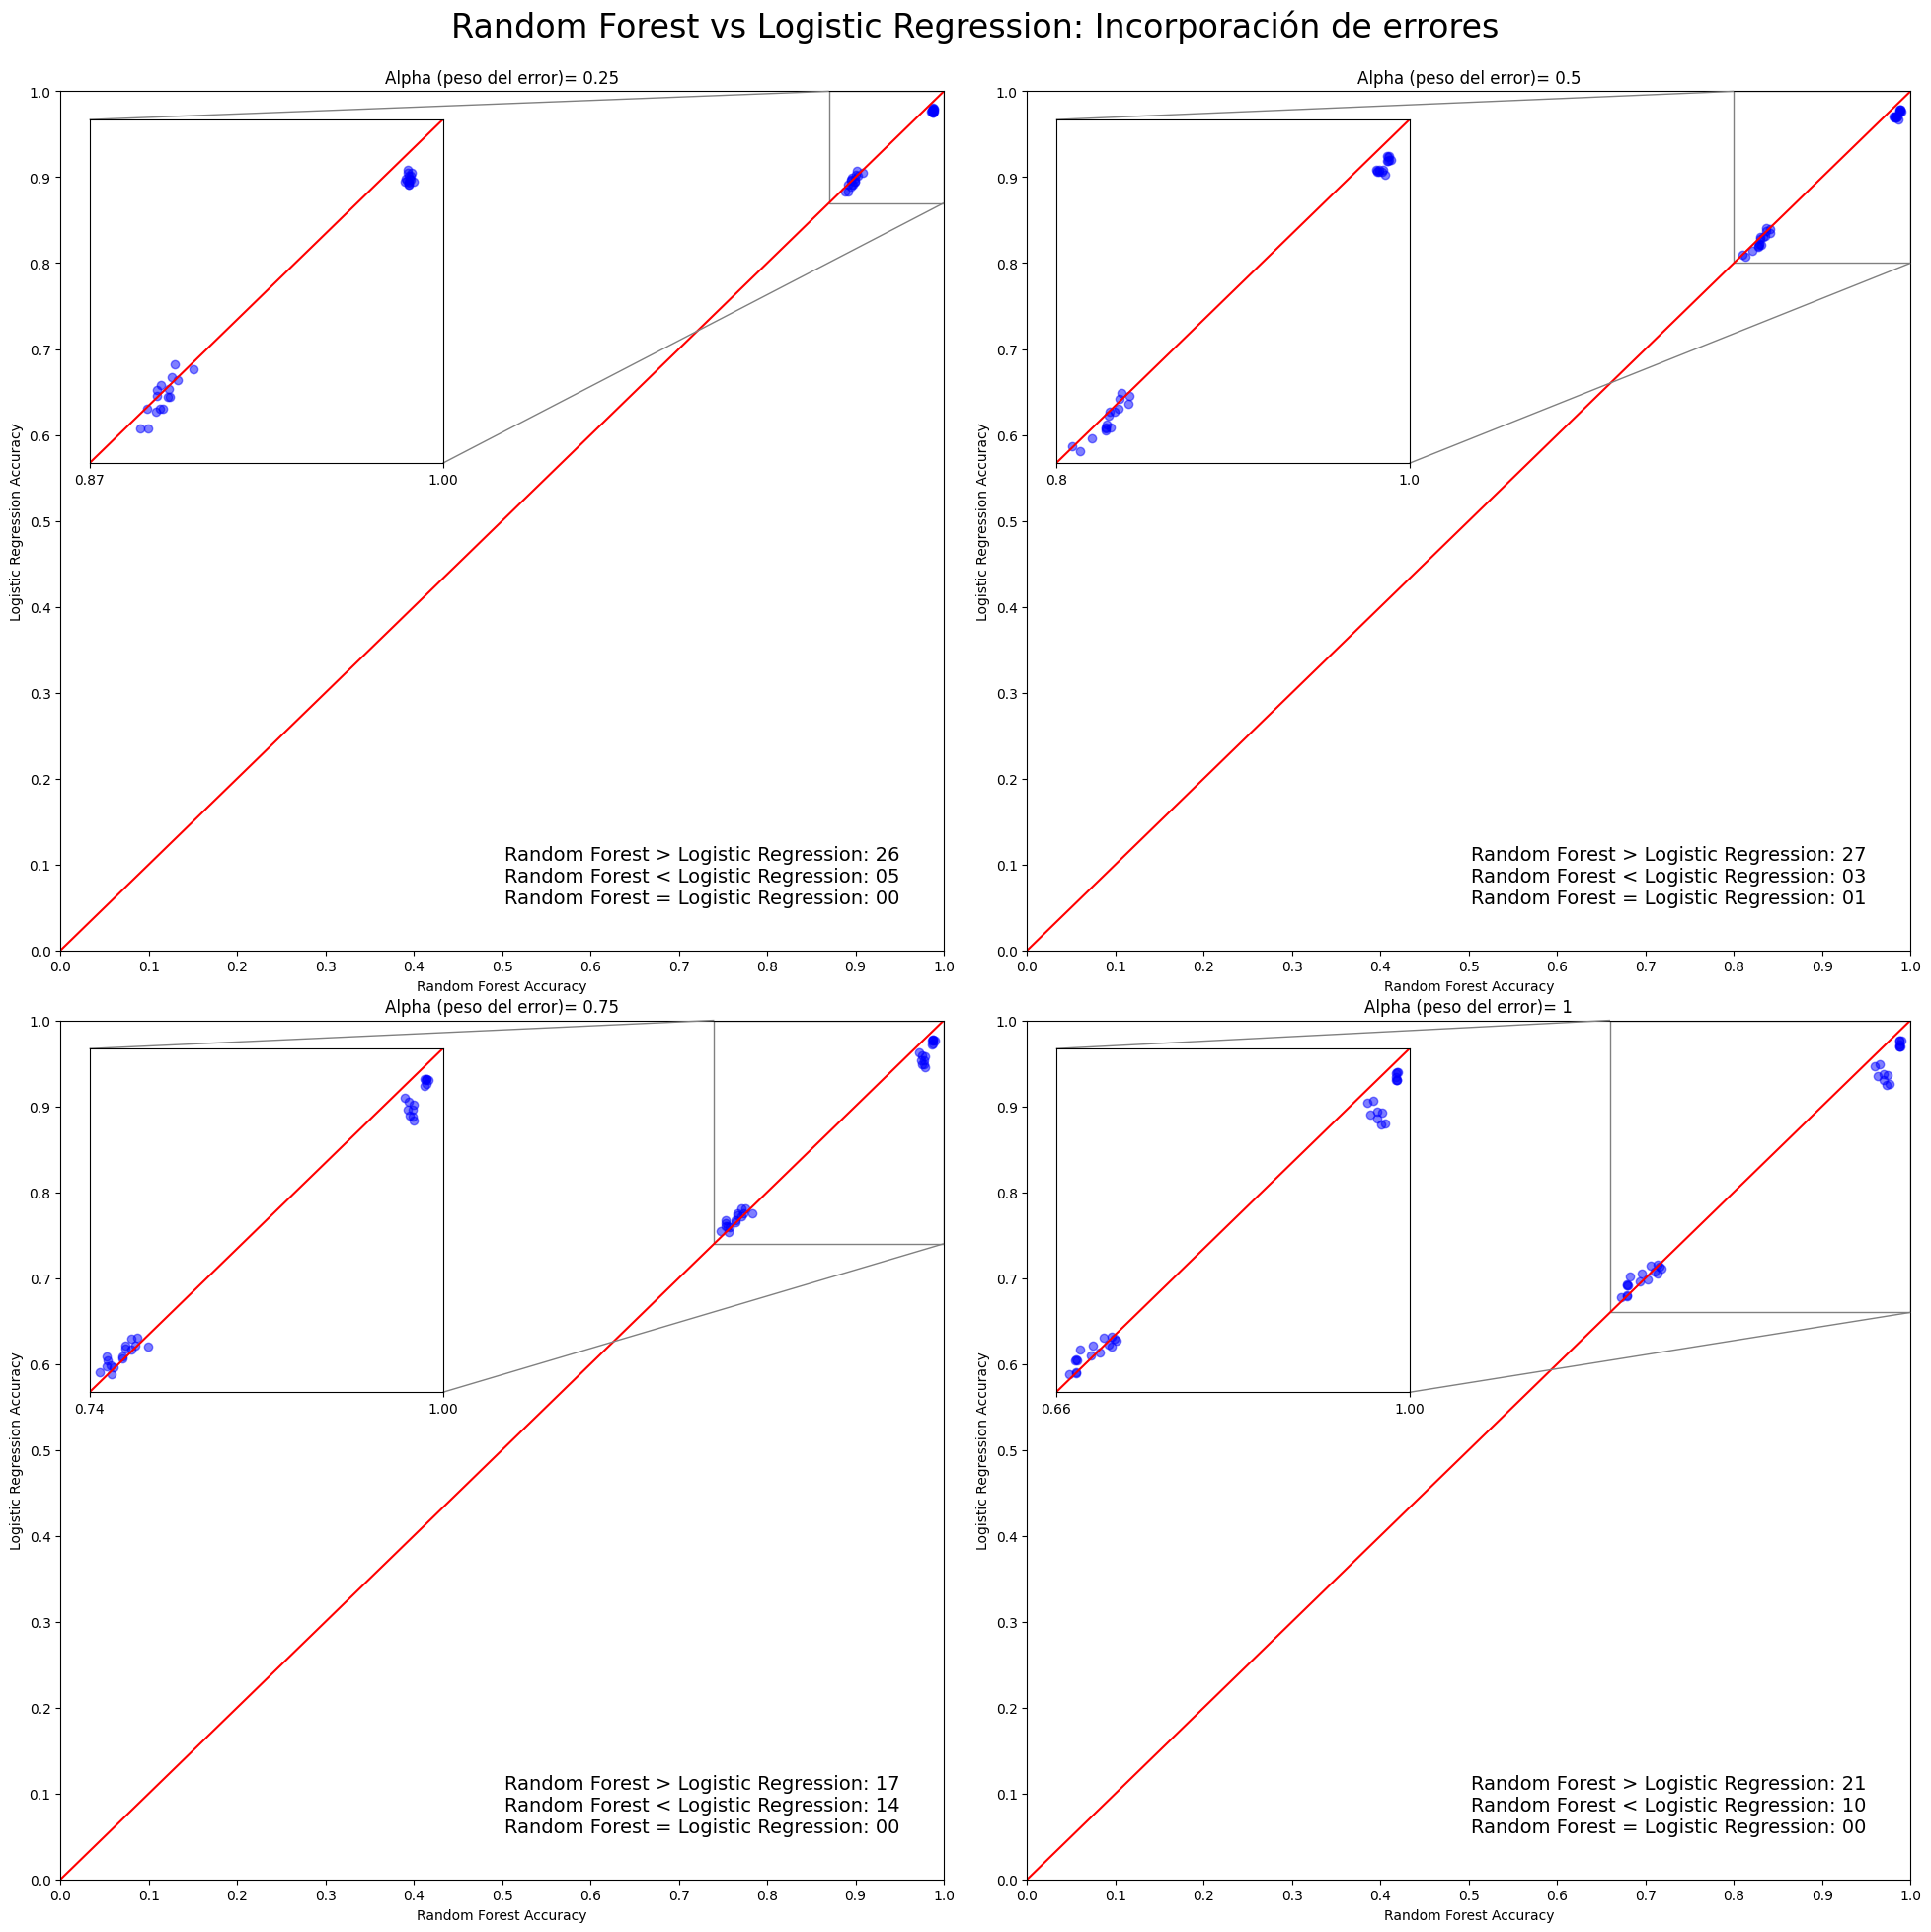

In [117]:
fig, axs = plt.subplots(2,2, figsize=(20,20))
fig.suptitle("Random Forest vs Logistic Regression: Incorporación de errores", fontsize=24)
fig.tight_layout(pad=3.0)
for (i, alfa) in enumerate(alfas):
    ax = axs[i//2, i%2]
    ax.scatter(
        [result[1] for result in results_error[i]],
        [result[2] for result in results_error[i]],
        c = 'b', alpha = 0.5
    )
    ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_title("Alpha (peso del error)= {}".format(alfa))
    ax.set_xlabel("Random Forest Accuracy")
    ax.set_ylabel("Logistic Regression Accuracy")
    ax.plot([0,1],[0,1], color="red")

    min_acc = round(min([result[1] for result in results_error[i]] + [result[2] for result in results_error[i]]),2) - 0.01

    ax_inset = inset_axes(ax, width="40%", height="40%", loc=2, bbox_to_anchor=(0.025, -0.025, 1, 1), bbox_transform=ax.transAxes)
    ax_inset.set_xlim(min_acc, 1)
    ax_inset.set_ylim(min_acc, 1)
    ax_inset.scatter(
        [result[1] for result in results_error[i]],
        [result[2] for result in results_error[i]],
        c = 'b', alpha = 0.5
    )
    ax_inset.plot([0,1],[0,1], color="red")
    ax_inset.set_xticks([min_acc, 1])
    ax_inset.set_yticks([])
    
    mark_inset(ax, ax_inset, loc1=2, loc2=4, fc="none", ec="0.5")
    ax.text(0.95, 0.05,"""Random Forest > Logistic Regression: {:02d}\nRandom Forest < Logistic Regression: {:02d}\nRandom Forest = Logistic Regression: {:02d}""".format(
        sum(np.array([result[1] for result in results_error[i]])>np.array([result[2] for result in results_error[i]])),
        sum(np.array([result[1] for result in results_error[i]])<np.array([result[2] for result in results_error[i]])),
        sum(np.array([result[1] for result in results_error[i]])==np.array([result[2] for result in results_error[i]]))
    ), transform=ax.transAxes, ha='right', va='bottom', fontsize=14)
    # ax.legend()

plt.savefig("rf_vs_lr_con_error.png")
plt.show()
